# ECG Signal Classification with Deep Learning: Leveraging AutoEncoder for Accurate Arrhythmia Detection

### Connecting with the Google driver

DataSet Used: MIT-BIH Arrhythmia Database

https://drive.google.com/file/d/1qyX9jijxe-p9H3_Itjs-DJRzAht2NPvN/view?usp=drive_link

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


kaggle ECG Dataset: https://www.kaggle.com/datasets/sadmansakib7/ecg-arrhythmia-classification-dataset

### Importing the required dependencies

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

### Loading and Analysing the ECG Dataset

Loading ECG Dataset

In [3]:
filepath = '/content/drive/MyDrive/ECG Dataset/MIT-BIH Arrhythmia Database.csv'
data = pd.read_csv(filepath)

Exploratory ECG Dataset Analysis

In [4]:
data.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


In [5]:
data.shape

(100689, 34)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100689 entries, 0 to 100688
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   record          100689 non-null  int64  
 1   type            100689 non-null  object 
 2   0_pre-RR        100689 non-null  int64  
 3   0_post-RR       100689 non-null  float64
 4   0_pPeak         100689 non-null  float64
 5   0_tPeak         100689 non-null  float64
 6   0_rPeak         100689 non-null  float64
 7   0_sPeak         100689 non-null  float64
 8   0_qPeak         100689 non-null  float64
 9   0_qrs_interval  100689 non-null  int64  
 10  0_pq_interval   100689 non-null  int64  
 11  0_qt_interval   100689 non-null  int64  
 12  0_st_interval   100689 non-null  int64  
 13  0_qrs_morph0    100689 non-null  float64
 14  0_qrs_morph1    100689 non-null  float64
 15  0_qrs_morph2    100689 non-null  float64
 16  0_qrs_morph3    100689 non-null  float64
 17  0_qrs_morp

### Data Preprocessing

Extracted features and labels from the dataset

In [26]:
x_data = data.iloc[:, 2:]
y_label = data[['type']]

In [27]:
value_counts = y_label.value_counts()
print(value_counts)

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
dtype: int64


In [28]:
labels = value_counts.index.get_level_values('type').tolist()
labels

['N', 'VEB', 'SVEB', 'F', 'Q']

Visualized data distribution and class proportions using pie charts

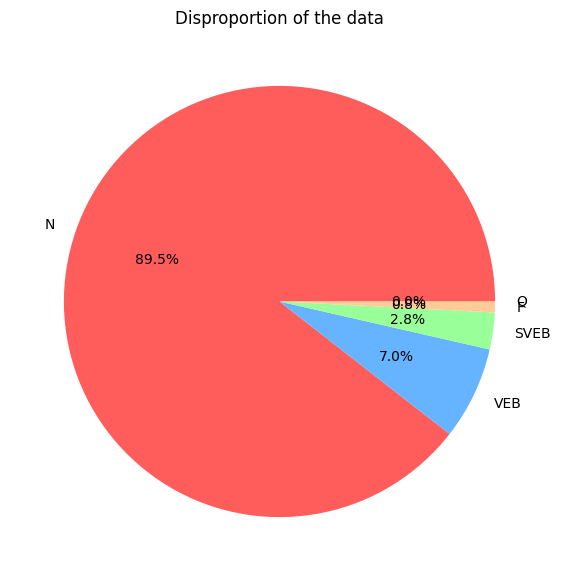

In [29]:
plt.figure(figsize=(7, 7))
my_circle = plt.Circle((0, 0), 0.7, color='white')

value_counts = y_label['type'].value_counts()
labels = value_counts.index.tolist()

plt.pie(value_counts, labels=labels, autopct='%1.1f%%', colors=['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Disproportion of the data')
plt.show()

In [30]:
original_class_distribution = data['type'].value_counts()
print("Original class distribution:")
print(original_class_distribution)

Original class distribution:
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: type, dtype: int64


Handled class imbalance by resampling data

In [31]:
majority_class = original_class_distribution.idxmax()
majority_class_count = original_class_distribution.max()

target_samples = majority_class_count

upsampled_data = pd.DataFrame()

for label in original_class_distribution.index:
    class_data = data[data['type'] == label]

    if label == majority_class:
        upsampled_data = pd.concat([upsampled_data, class_data])
    else:
        upsampled_data = pd.concat([upsampled_data, resample(class_data, replace=True, n_samples=target_samples, random_state=42)])

balanced_class_distribution = upsampled_data['type'].value_counts()
print("\nBalanced class distribution:")
print(balanced_class_distribution)


Balanced class distribution:
N       90083
VEB     90083
SVEB    90083
F       90083
Q       90083
Name: type, dtype: int64


Plot pie charts for the original and balanced class distributions

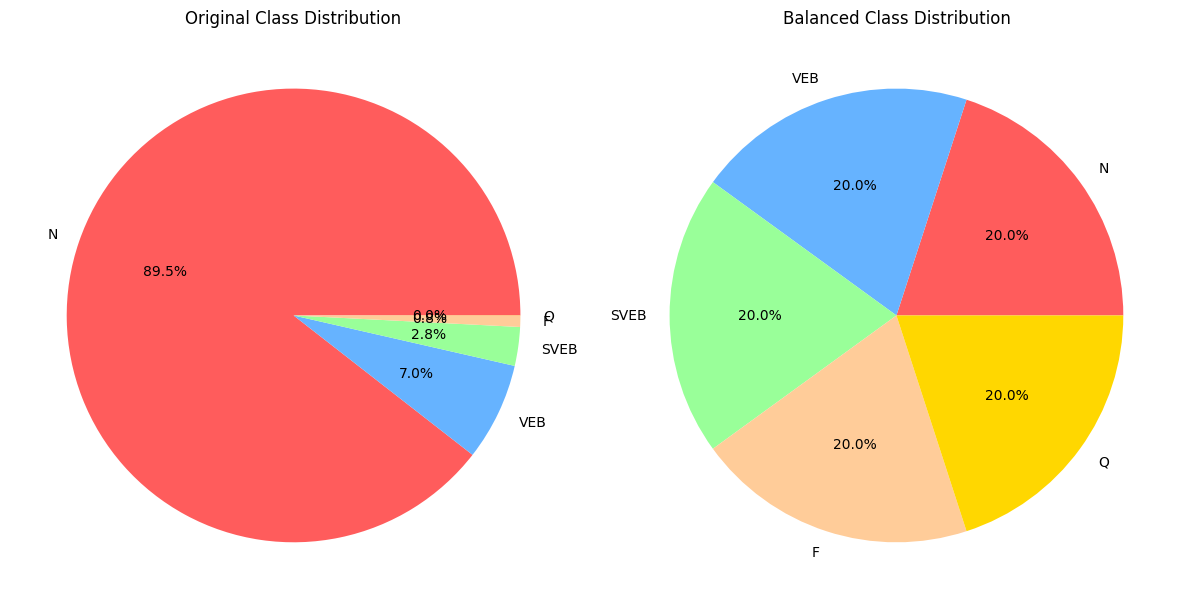

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(original_class_distribution, labels=original_class_distribution.index, autopct='%1.1f%%', colors=['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Original Class Distribution')

plt.subplot(1, 2, 2)
plt.pie(balanced_class_distribution, labels=balanced_class_distribution.index, autopct='%1.1f%%', colors=['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Balanced Class Distribution')

plt.tight_layout()
plt.show()


Handle class imbalance by resampling

In [33]:
upsampled_data = pd.DataFrame()
target_samples = y_label['type'].value_counts().max()

for label in y_label['type'].unique():
    class_data = data[data['type'] == label]
    if len(class_data) < target_samples:
        upsampled_data = pd.concat([upsampled_data, resample(class_data, replace=True, n_samples=target_samples, random_state=42)])
    else:
        upsampled_data = pd.concat([upsampled_data, class_data])

Resampled data

In [34]:
x_data = upsampled_data.iloc[:, 2:]
y_label = upsampled_data[['type']]

### Label Encoding

Encoded categorical labels

In [37]:
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(y_label['type'])
y_label_one_hot = to_categorical(y_label_encoded)

### Data Splitting

Split the data into training and testing sets

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_label_one_hot, test_size=0.2, random_state=42)

### Scaling and Reshape

Scaled the feature data

In [39]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Reshape for  Autoencoder input

In [40]:
x_train_reshaped = x_train_scaled[..., np.newaxis]
x_test_reshaped = x_test_scaled[..., np.newaxis]

print("x_train_reshaped shape:", x_train_reshaped.shape)
print("y_train shape:", y_train.shape)
print("x_test_reshaped shape:", x_test_reshaped.shape)
print("y_test shape:", y_test.shape)

x_train_reshaped shape: (360332, 32, 1)
y_train shape: (360332, 5)
x_test_reshaped shape: (90083, 32, 1)
y_test shape: (90083, 5)


### Model Architecture


Defined a Convolutional Neural Network (CNN) model using TensorFlow and Keras

In [46]:
model = Sequential()

# Encoding
model.add(Dense(units=128, activation='relu', input_shape=(x_train_reshaped.shape[1],1)))
model.add(Dense(units=64, activation='relu'))

# Decoding
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=x_train_reshaped.shape[1], activation='linear'))

Compile the model

In [47]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Model Training

Train the model

In [48]:
history = model.fit(x_train_reshaped, x_train_reshaped, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
9009/9009 [==============================] - 128s 10ms/step - loss: 0.0024 - val_loss: 2.8332e-06
Epoch 2/20
9009/9009 [==============================] - 83s 9ms/step - loss: 1.3702e-05 - val_loss: 3.7672e-08
Epoch 3/20
9009/9009 [==============================] - 85s 9ms/step - loss: 8.5608e-06 - val_loss: 1.6663e-08
Epoch 4/20
9009/9009 [==============================] - 89s 10ms/step - loss: 8.0849e-06 - val_loss: 1.6396e-08
Epoch 5/20
9009/9009 [==============================] - 83s 9ms/step - loss: 7.5268e-06 - val_loss: 1.6893e-08
Epoch 6/20
9009/9009 [==============================] - 83s 9ms/step - loss: 9.7128e-06 - val_loss: 1.7104e-08
Epoch 7/20
9009/9009 [==============================] - 84s 9ms/step - loss: 5.9714e-06 - val_loss: 9.4312e-09
Epoch 8/20
9009/9009 [==============================] - 87s 10ms/step - loss: 5.5299e-06 - val_loss: 2.4087e-08
Epoch 9/20
9009/9009 [==============================] - 86s 10ms/step - loss: 6.6433e-06 - val_loss: 1.2854e-08


### Evaluate the model on the test set

In [49]:
reconstructed_data = model.predict(x_test_reshaped)

2816/2816 [==============================] - 14s 5ms/step


Plot original vs reconstructed samples

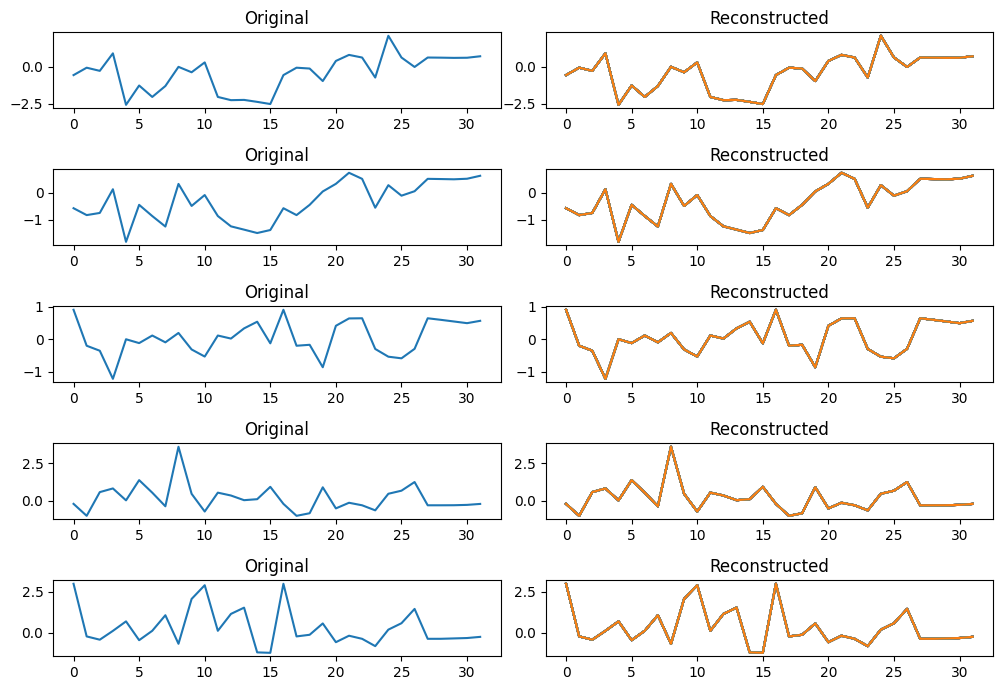

In [50]:
plt.figure(figsize=(10, 7))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.plot(x_test_scaled[i])
    plt.title('Original')
    plt.subplot(5, 2, 2 * i + 2)
    plt.plot(reconstructed_data[i])
    plt.title('Reconstructed')
plt.tight_layout()
plt.show()

In [51]:
y_test_pred_probs = model.predict(x_test_reshaped)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
print(y_test_pred)

2816/2816 [==============================] - 13s 5ms/step
[[24 24 24 ... 24 24 24]
 [21 21 21 ... 21 21 21]
 [ 0  0  0 ...  0  0  0]
 ...
 [13 13 13 ... 13 13 13]
 [19 19 19 ... 19 19 19]
 [ 5  5  5 ...  5  5  5]]


### Final Result Visualization

Plotting the loss

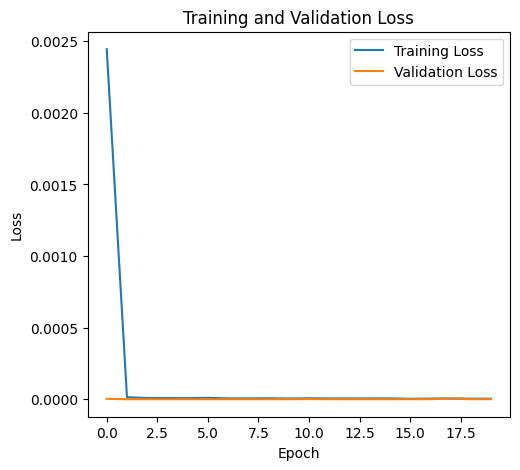

In [52]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Plotting validation loss

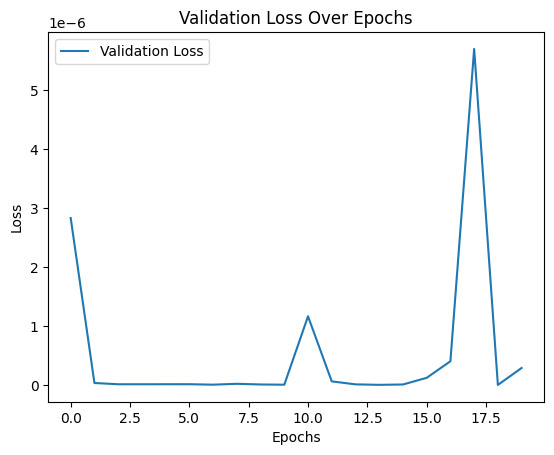

In [53]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model summary

About Model

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32, 128)           256       
                                                                 
 dense_5 (Dense)             (None, 32, 64)            8256      
                                                                 
 dense_6 (Dense)             (None, 32, 128)           8320      
                                                                 
 dense_7 (Dense)             (None, 32, 32)            4128      
                                                                 
Total params: 20960 (81.88 KB)
Trainable params: 20960 (81.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
